<a href="https://colab.research.google.com/github/bailejor/SAMSHA_Transfer_Learning/blob/main/Random_forest_methadone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score, make_scorer, precision_score, recall_score, confusion_matrix, precision_recall_curve, fbeta_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': {0: 20, 1: 80}, 'bootstrap': True}
0.39325607353687136
5290 1400 877 799
The ROC_AUC score is: 0.6337313733674383
The Balanced Accuracy Score is: 0.6337313733674383
The Accuracy Score is: 0.7278269184795602
The positive precision is: 0.3633469758981355
The positive recall is: 0.4767303102625298
The negative precision is: 0.8577914707313118
The negative recall is: 0.7907324364723468
The f0.5 score is: 0.38149350649350655
(8366,)


Text(0, 0.5, 'Precision')

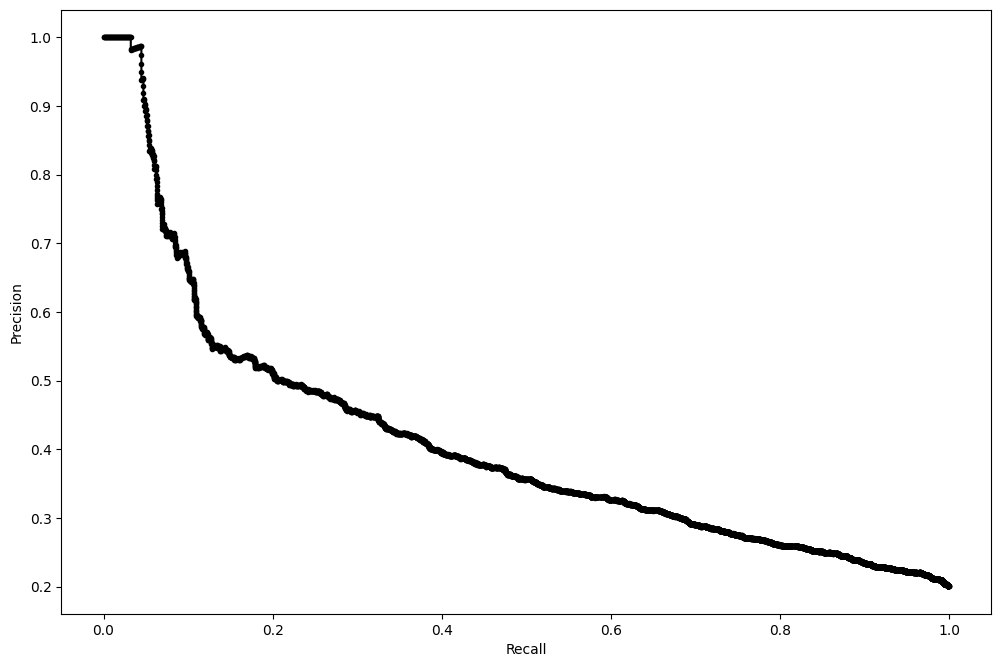

In [8]:



df = pd.read_csv('/content/drive/MyDrive/tedsd_puf_2018.csv', header  = 0)


df = pd.concat([df])
df = df.drop_duplicates(subset = ['CASEID'], keep = 'first')
df['REASON'].replace({2:0, 3:0, 4:0, 5:0, 6:0, 7:0}, inplace = True)
df = df[['CASEID', 'AGE', 'GENDER', 'RACE', 'ETHNIC', 'MARSTAT', 'EDUC', 'VET', 'PREG', 'EMPLOY', 'LIVARAG', 'ARRESTS',  'METHUSE', 'PSOURCE','NOPRIOR', 'SUB1', 'FREQ1', 'FRSTUSE1', 'SUB2', 'SUB3', 'ROUTE1', 'ROUTE2', 'ROUTE3', 'ALCFLG', 'COKEFLG', 'MARFLG', 'METHFLG', 'OPSYNFLG','HERFLG', 'SERVICES', 'SERVICES_D', 'REASON']]





types_of_services = [6, 7, 8]
methadone_use_false = [2]
methadone_use_true = [1]
sub_1_opiates = [5, 6, 7]
sub_1_others = [1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

#Keep only outpatient patients
df_others = df.loc[df['SERVICES'].isin(types_of_services)]
df_others = df_others.loc[df_others['SUB1'].isin(sub_1_others)]

#Create second dataframe with just methadone treatment patients
df_methadone = df

#Keep only patients who did not have methadone treatment
df_others = df_others.loc[df_others['METHUSE'].isin(methadone_use_false)]
df_methadone = df_methadone.loc[df_methadone['METHUSE'].isin(methadone_use_true)]
#Return patients whose primary substance use is opiates
df_methadone = df_methadone.loc[df_methadone['SUB1'].isin(sub_1_opiates)]

#df_methadone = df_methadone.sample(n=500, random_state = 33)
#print(df_methadone['REASON'].value_counts())

data2 = df_others.values
#Select other substances or 
data = df_methadone.values
X = data[:,1:29]
y = data[:,31:32].ravel()

X_train, X_test10, y_train, y_test10 = train_test_split(X, y, test_size=0.10, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_test10, y_test10, test_size=0.50, random_state=33)


param_grid = {'bootstrap':[True, False],
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf':[1, 2, 4],
'min_samples_split':[2, 5, 10],
'n_estimators': [50, 200, 400, 600, 800, 1000],
'class_weight': [{0:50, 1:50}, {0:10, 1:90}, {0:20, 1:80}, {0:30, 1:70}, None]}

roc_auc = make_scorer(roc_auc_score)
balanced = make_scorer(balanced_accuracy_score)
acc = make_scorer(accuracy_score)
fbeta = make_scorer(fbeta_score, beta = 0.5)

rf = RandomForestClassifier(random_state= 33)

clf = RandomizedSearchCV(rf, param_grid, n_iter = 10, scoring = fbeta, n_jobs = 4, cv = 3, random_state = 33)
search = clf.fit(X_val, y_val)
print(search.best_params_)
print(search.best_score_)


rf2 = RandomForestClassifier(**search.best_params_)
rf2.fit(X_val, y_val)

yhat = rf2.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()

score1 = roc_auc_score(y_test, yhat)
score2 = balanced_accuracy_score(y_test, yhat)
score3 = accuracy_score(y_test, yhat)

pos_precision = precision_score(y_test, yhat, pos_label = 1)
pos_recall = recall_score(y_test, yhat, pos_label = 1)

neg_precision = precision_score(y_test, yhat, pos_label = 0)
neg_recall = recall_score(y_test, yhat, pos_label = 0)
fbeta_s = fbeta_score(y_test, yhat, beta = 0.5)
print(tn, fp, fn, tp)


print("The ROC_AUC score is: " + str(score1))
print("The Balanced Accuracy Score is: " + str(score2))
print("The Accuracy Score is: " + str(score3))

print("The positive precision is: " + str(pos_precision))
print("The positive recall is: " + str(pos_recall))
print("The negative precision is: " + str(neg_precision))
print("The negative recall is: " + str(neg_recall))
print("The f0.5 score is: " +str(fbeta_s))


rf_thresh = rf2.predict_proba(X_test)[:, 1].flatten()
print(rf_thresh.shape)
precision, recall, thresholds = precision_recall_curve(y_test, rf_thresh)

pyplot.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pyplot.plot(recall, precision, marker='.', label='Base CNN', color = 'k')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
